In [2]:

import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
import pydot
import graphviz

#!pip install tensorflow==2.14
#!pip install pydot
#!pip install seaborn
#!pip install graphviz

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.model_selection import StratifiedShuffleSplit

2.13.0


In [3]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [4]:
# Load the data
X = np.load('/kaggle/input/datidati/training_data.npy')
categories = np.load("/kaggle/input/datidati/categories.npy")
valid_periods = np.load('/kaggle/input/datidati/valid_periods.npy')

In [5]:
def remove_padding(series, valid_period):
    start, end = valid_period
    return series[start:end]

def encode_categories(categories):
    # Integer encoding of categorical data (letters)
    unique_categories = np.unique(categories)
    category_to_int = {category: i for i, category in enumerate(unique_categories)}
    return np.array([category_to_int[category] for category in categories])

In [ ]:
'''
# Create a mask for non-zero values
non_zero_mask = np.array(X) != 0

scaled_data = np.zeros_like(X, dtype=np.float64)

for i in range(X.shape[1]):  # Assuming data is a 2D array with shape (num_timestamps, num_variables)
    non_zero_data = X[non_zero_mask[:, i], i].reshape(-1, 1)
    scaled_non_zero_data = scaler.fit_transform(non_zero_data)
    scaled_data[non_zero_mask[:, i], i] = scaled_non_zero_data.flatten()

scaled_data.shape
#X=scaled_data
'''

In [6]:
X = np.load('/kaggle/input/datidati/training_data.npy')

# Create an empty list to store scaled rows
X_scaled=X.copy()

# Convert scales and centers lists to NumPy arrays
scales = np.zeros(X.shape[0])
centers = np.zeros(X.shape[0])

strange_s=[]
strange_c=[]

# Scale each row of X independently
for i in range(X.shape[0]):  # Loop over each row

    # Create a mask for non-zero values in the current row
    non_zero_mask = (X[i, :] != 0.0)

    # Extract non-zero values for fitting the scaler
    non_zero_data = X[i, non_zero_mask].reshape(-1, 1)

    # Initialize the scaler and fit on non-zero data
    scaler = RobustScaler().fit(non_zero_data)

    # Save the scale and center for the current row
    scales[i]=scaler.scale_[0]
    centers[i]=scaler.center_[0]
    
    if (scales[i]>0.9 or scales[i]<0.05):
        strange_s.append(i)
        
    if (centers[i]>0.9 or centers[i]<0.05):
        strange_c.append(i)

    # Transform the entire row using the fitted scaler
    X_scaled_row = scaler.transform(X[i, non_zero_mask].reshape(-1, 1)).flatten()

    # Fill the non-zero elements with the scaled values
    X_scaled[i, non_zero_mask] = X_scaled_row


print(X_scaled.shape, scales.shape,centers.shape, len(strange_s), len(strange_c))

(48000, 2776) (48000,) (48000,) 365 361


In [7]:
start_times = valid_periods[:,0]
end_times = valid_periods[:,1]

'\n\n# Create a  grid of subplots\nfig, axs = plt.subplots(30, 10, figsize=(12, 12))\n\n# Loop through each index in strange_s and plot the corresponding data\nfor i, index in enumerate(strange_s):\n    row, col = divmod(i, 30)  # Calculate the row and column for the subplot\n    subplot_ax = axs[row, col]  # Get the axis for the current subplot\n\n    # Assuming X is your data\n    subplot_ax.plot(X[index, start_times[index]:end_times[index]])\n    subplot_ax.set_title(categories[index])\n\n\n# Adjust layout to prevent clipping of subplot titles or labels\nplt.tight_layout()\n\n# Show the plots\nplt.show()\n'

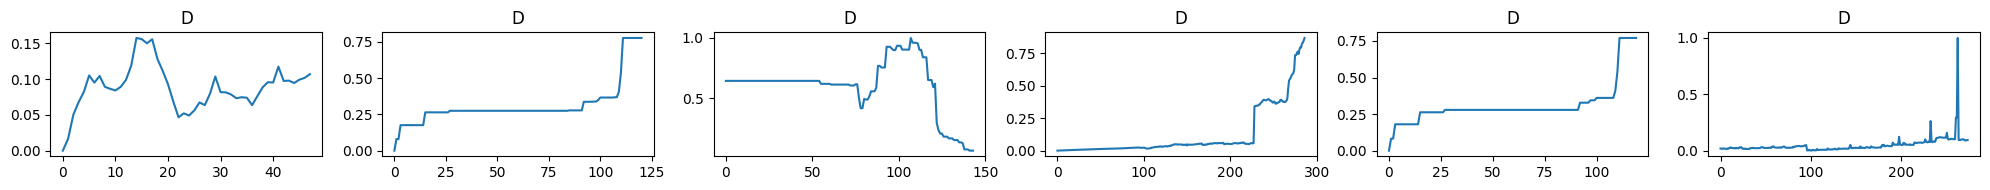

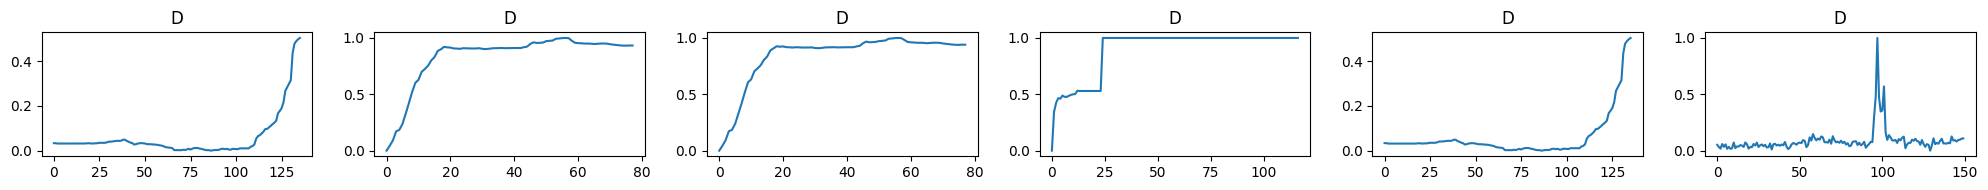

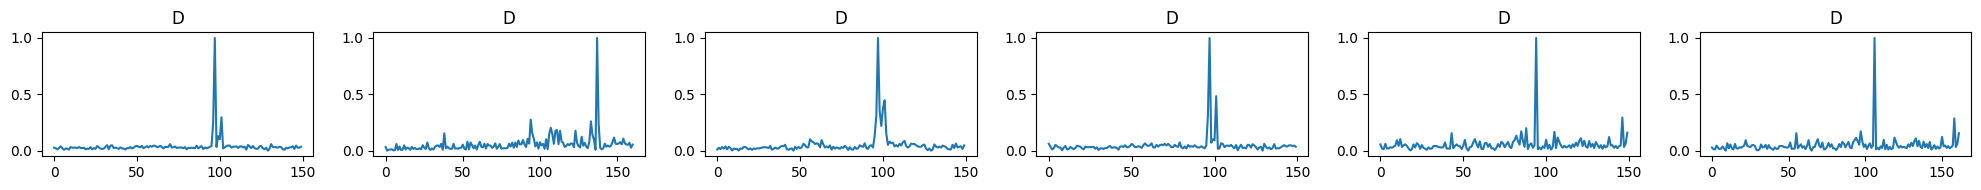

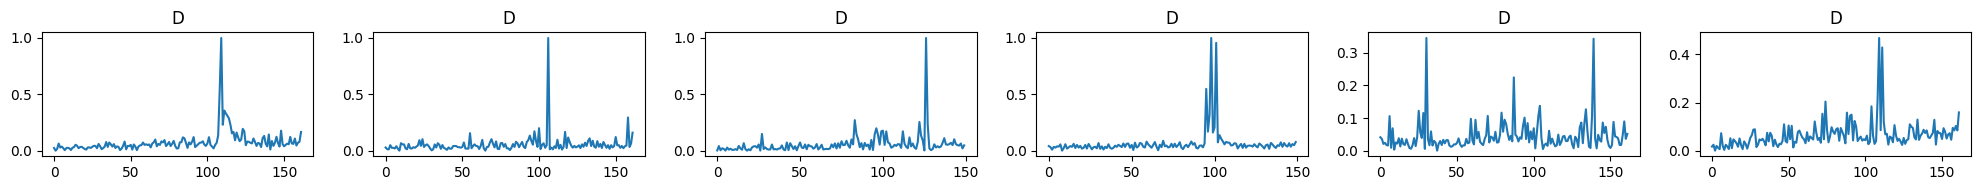

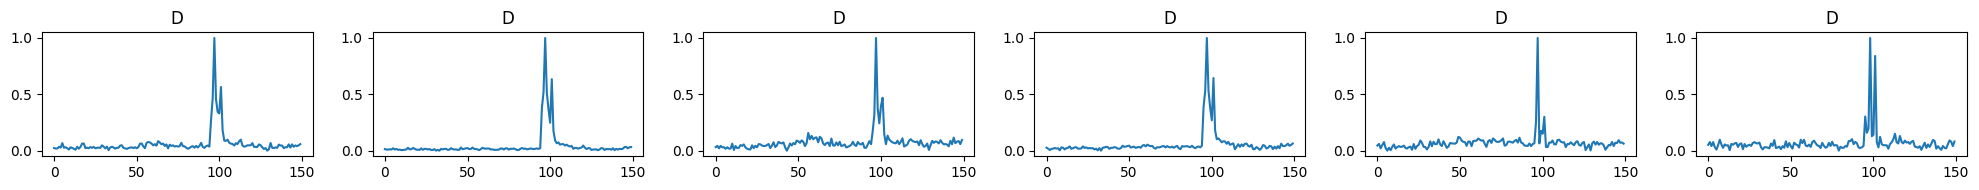

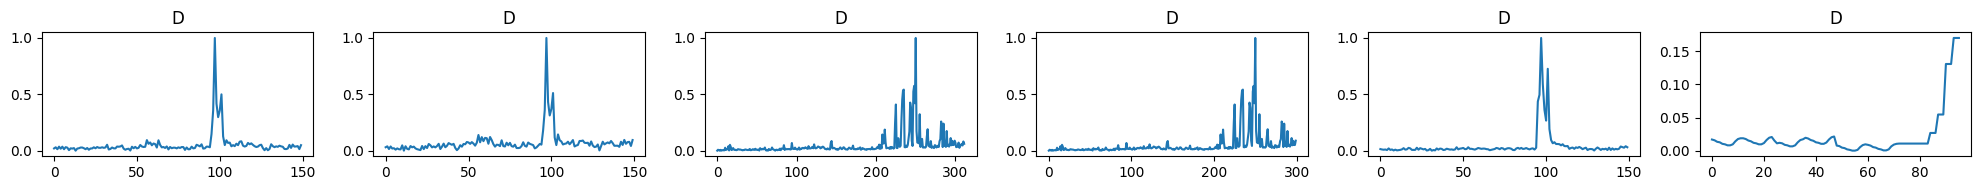

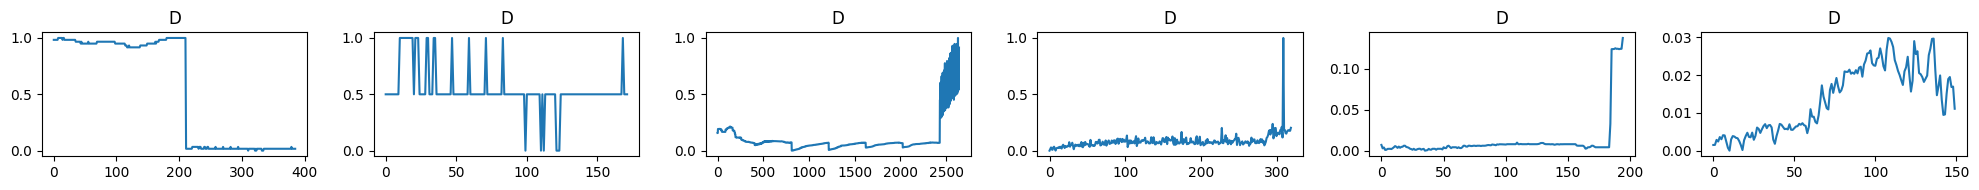

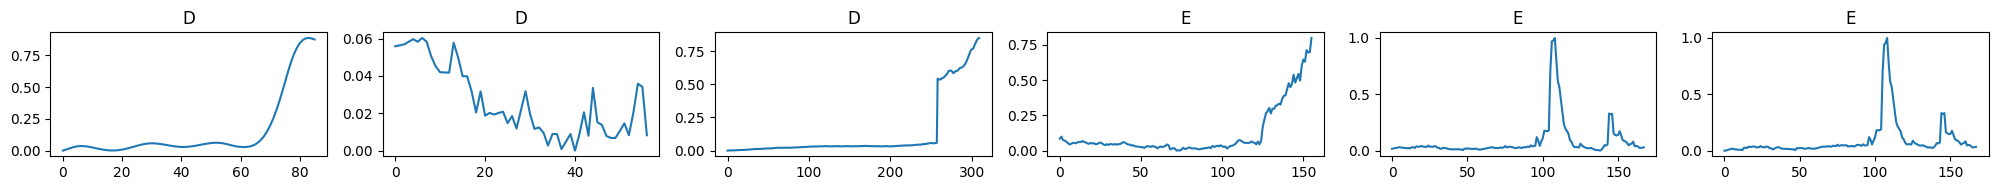

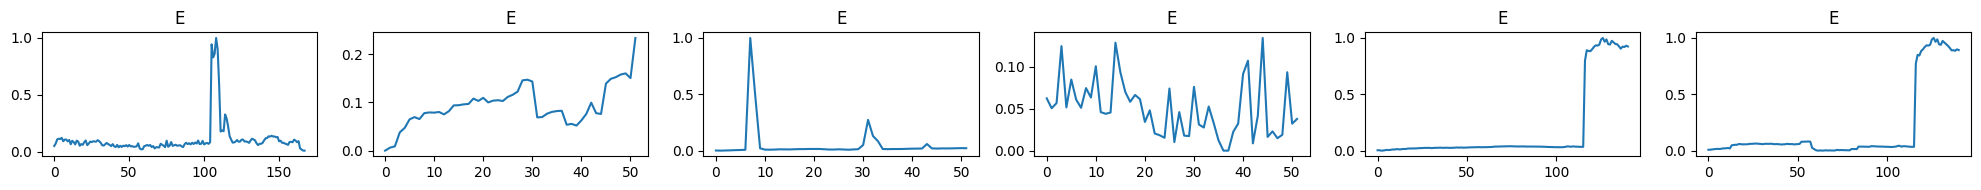

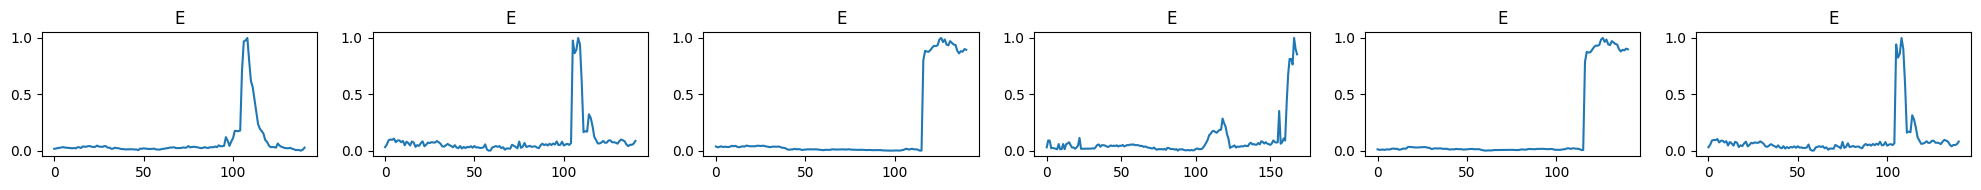

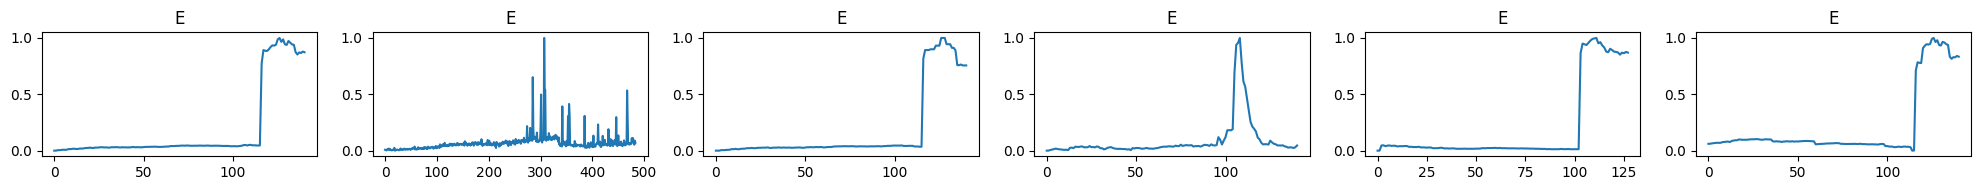

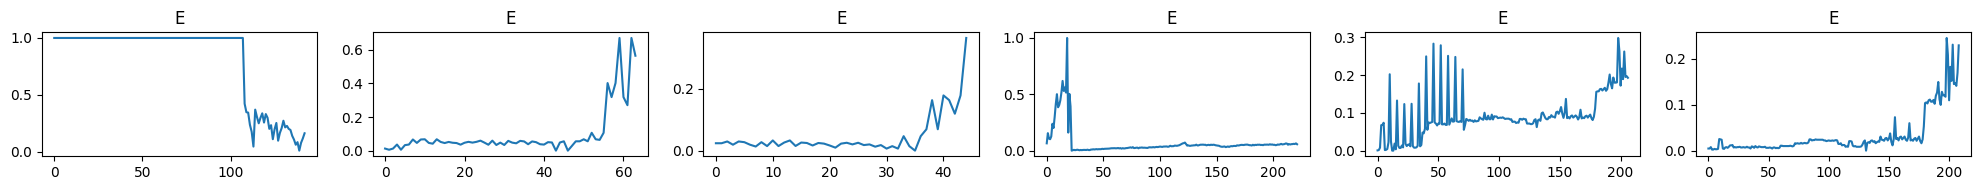

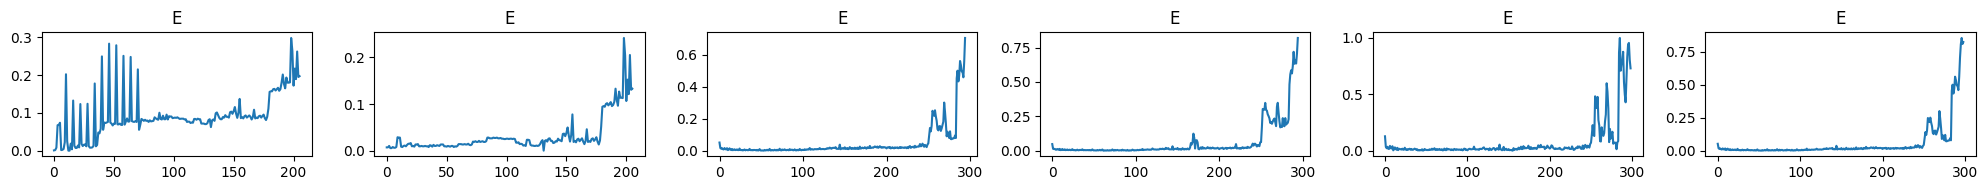

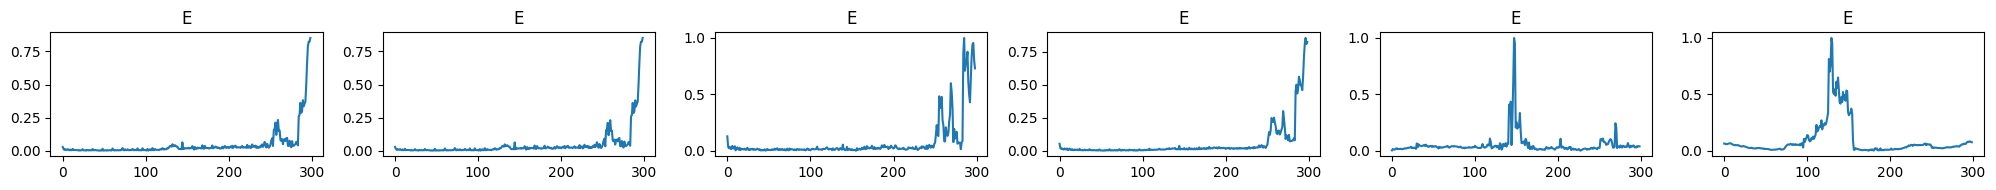

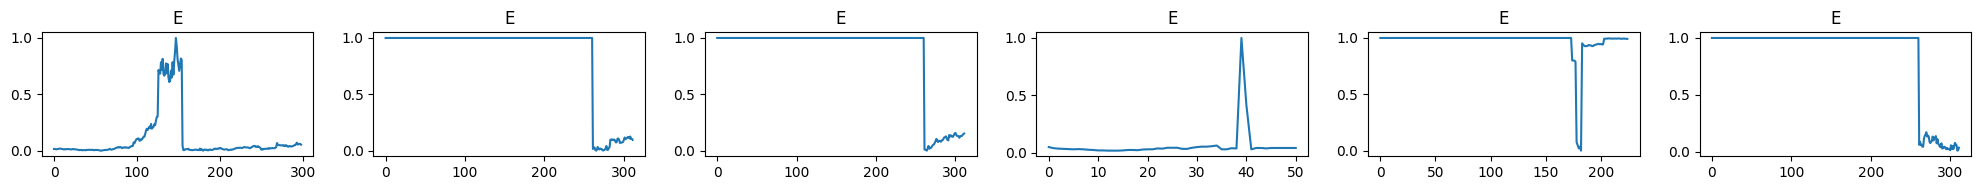

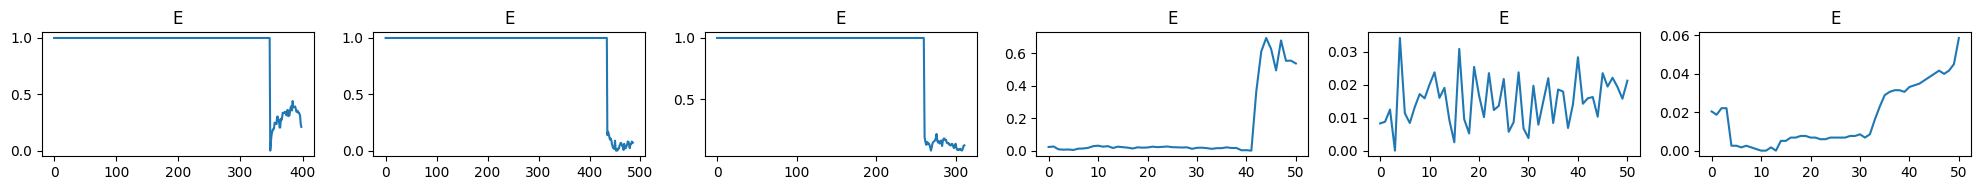

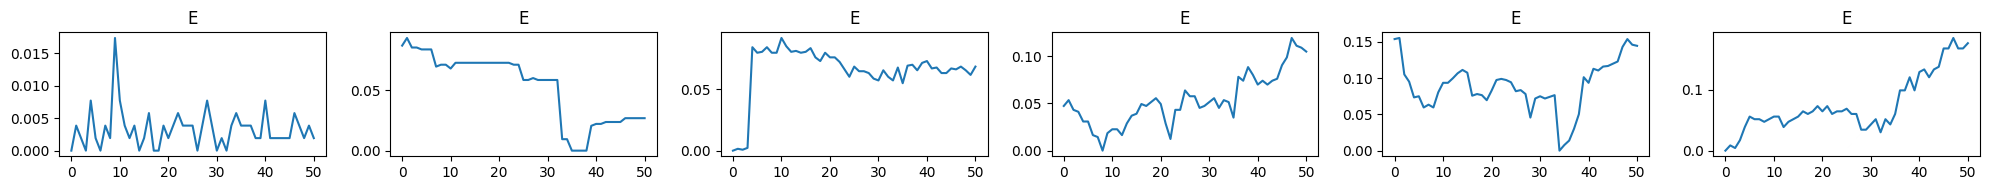

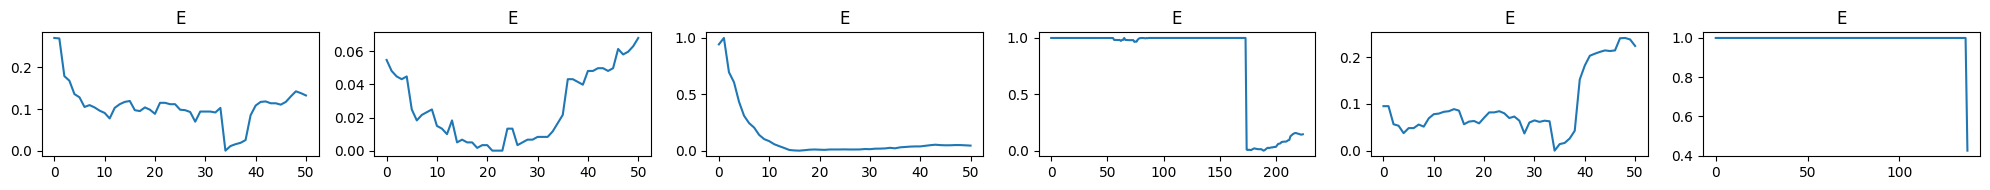

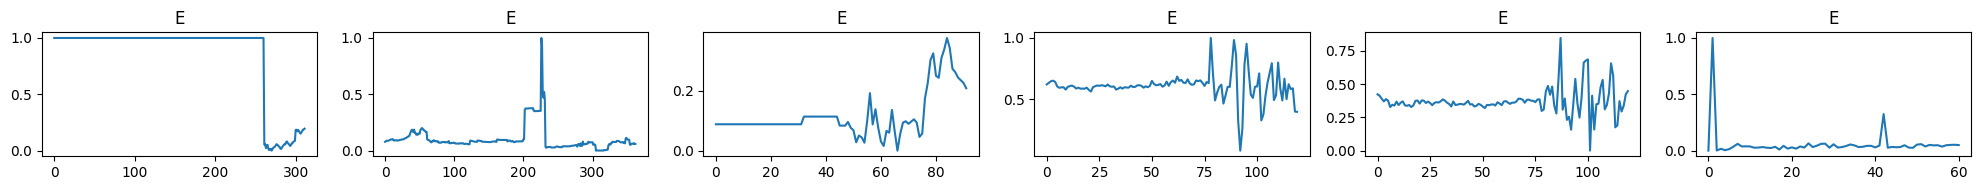

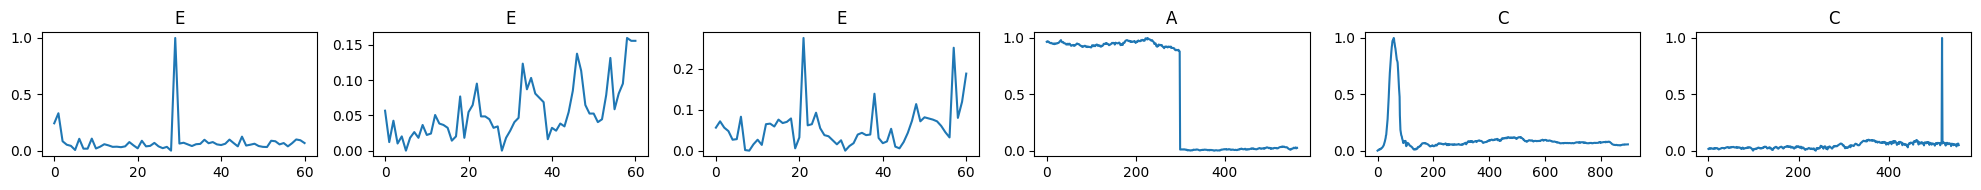

In [8]:
# Create subplots for each row
N_rows = 20
N_cols = 6

for row in range(N_rows):
    # Create a new figure for each row
    fig, axs = plt.subplots(1, N_cols, figsize=(20, 2))

    # Loop through each subplot in the row
    for col in range(N_cols):
        index = row * N_cols + col

        if index < len(strange_s):  # Ensure the index is within the valid range
            subplot_ax = axs[col]

            # Plot the scaled sequence
            subplot_ax.plot(X[strange_s[index], start_times[strange_s[index]]:end_times[strange_s[index]]])
            subplot_ax.set_title(categories[strange_s[index]])

    # Adjust layout to prevent clipping of subplot titles or labels
    plt.tight_layout()

    # Show the current figure
    plt.show()

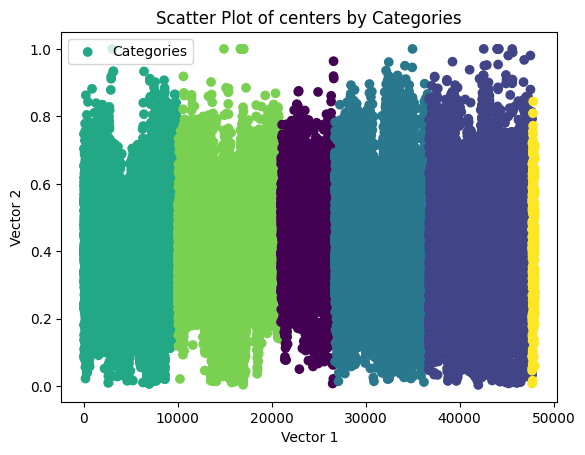

In [12]:
categories= encode_categories(categories)

#Plot scaled by categories


# Create scatter plot with category-based color code
plt.scatter(range(len(centers)), centers, c=categories, cmap='viridis', label='Categories')

# Add labels and title
plt.xlabel('Vector 1')
plt.ylabel('Vector 2')
plt.title('Scatter Plot of centers by Categories')
plt.legend()
plt.show()

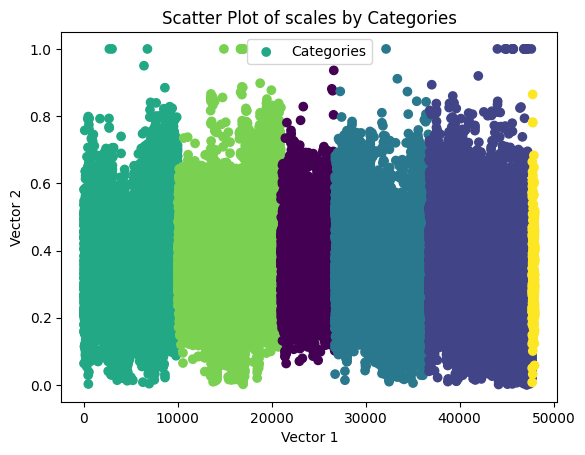

In [13]:
# Create scatter plot with category-based color code
plt.scatter(range(len(scales)), scales, c=categories, cmap='viridis', label='Categories')

# Add labels and title
plt.xlabel('Vector 1')
plt.ylabel('Vector 2')
plt.title('Scatter Plot of scales by Categories')
plt.legend()
plt.show()

(48000,)


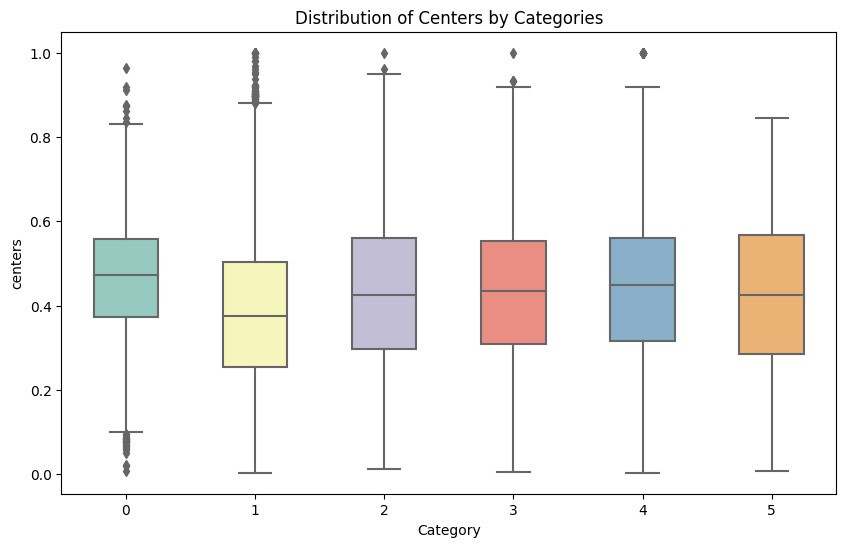

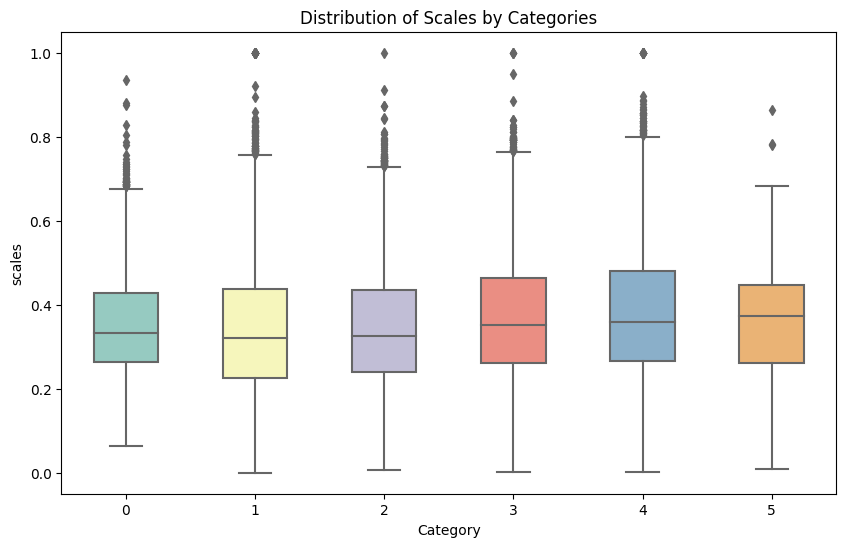

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

print(centers.shape )

# Combine data and categories into a DataFrame
import pandas as pd
df = pd.DataFrame({'centers': centers, 'scales': scales, 'Category': categories})

# Create a boxplot or violin plot
plt.figure(figsize=(10, 6))
sns.boxplot(x='Category', y='centers', data=df, width=0.5, palette="Set3")
plt.title('Distribution of Centers by Categories')
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(x='Category', y='scales', data=df, width=0.5, palette="Set3")
plt.title('Distribution of Scales by Categories')
plt.show()


## The robust scales (IQR) and the centers (medians) seem similarly distributed across the cateories, although there seem to be some outliers that we will remove in the other notebooks. 

## These results suggest that there is no strict need (based on these data) to include the categories in the model